In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns

In [60]:
# Create a function to convert Celsius to the nearest 10th of a degree to Fahrenheit
def convert_c_10th_to_f(temp: int) -> float:
    '''
    Convert Celsius to the nearest tenth to Fahrenheit
    
    :param temp: the temperature as the nearest tenth of a degree Celsius
    :returns: the temperature in Fahrenheit
    '''
    # Convert C to the nearest tenth to C
    c_temp = temp/10
    # Convert C to F
    f_temp = round((c_temp * 9/5) + 32)
    
    return f_temp

In [61]:
# Create a function to get consecutive days above a specific temperature
def get_consecutive_days_above_temp(day_temps: pd.Series, temp: int) -> int:
    '''
    Get the number of consecutive days above a specified temperature
    
    :param day_temps: a pandas Series object representing the temperature for each day
    :param temp: the temperature for which the consecutive days are measured against
    :returns: the number of consecutive days surpassing the temp parameter
    '''
    # Start off with 0 consecutive days
    current_consecutive_days = 0
    max_consecutive_days = 0
    # Evaluate the days
    for day_temp in day_temps:
        if day_temp >= temp:
            current_consecutive_days += 1
        else:
            # If the streak ends, check if it is the new maximum
            max_consecutive_days = current_consecutive_days if max_consecutive_days < current_consecutive_days else max_consecutive_days
            # Reset the days
            current_consecutive_days = 0
    
    return max_consecutive_days

In [62]:
# Import the data
filename = 'PhoenixWeather.csv'
df = pd.read_csv(filename, usecols=['DATE', 'PRCP', 'TMAX'])
# Rename the columns
df.columns = ['Date', 'Precipitation_mm', 'Temp_C']
# Clean up the NaN values
df.fillna(0, inplace=True)
# Convert the date column to a Date type
df['Date'] = pd.to_datetime(df['Date'])
# Convert the temperatures to Fahrenheit
df['Temp_F'] = df['Temp_C'].apply(convert_c_10th_to_f)
# Convert mm to the nearest 10th to inches
df['Precipitation_in'] = df['Precipitation_mm']/254
# Only get the years 1970 and up
df = df[df['Date'] >= '1970']
# Preview the data
df.head()

,Date,Precipitation_mm,Temp_C,Temp_F,Precipitation_in
11471,1970-01-01,0.0,139.0,57,0.0
11472,1970-01-02,0.0,128.0,55,0.0
11473,1970-01-03,0.0,150.0,59,0.0
11474,1970-01-04,0.0,161.0,61,0.0
11475,1970-01-05,0.0,144.0,58,0.0


In [65]:
# Get the average temperature for each summer month (June - August)
summer_months = df['Date'].dt.month.isin([6, 7, 8])
average_summer_temps = df[summer_months].groupby(df[summer_months]['Date'].dt.strftime('%Y'))['Temp_F'].mean().reset_index()
# Convert the Date column to a datetime object
average_summer_temps['Date'] = pd.to_datetime(average_summer_temps['Date'])
# Preview the data
average_summer_temps.head()

,Date,Temp_F
0,1970-01-01,104.641304
1,1971-01-01,102.945652
2,1972-01-01,103.402174
3,1973-01-01,105.532609
4,1974-01-01,106.010870


In [73]:
# Get the number of days with 100+ temps per year
days_over_100 = df.groupby(df['Date'].dt.year)['Temp_F'].agg(lambda x: x.ge(100).sum())
# Get the number of days with 110+ temps per year
days_over_110 = df.groupby(df['Date'].dt.year)['Temp_F'].agg(lambda x: x.ge(110).sum())
hundred_temperatures = pd.concat({
    'Days_Over_100':days_over_100, 
    'Days_Over_110': days_over_110
}, axis=1)
# Reset the index
hundred_temperatures.reset_index(inplace=True)
# Preview the data
hundred_temperatures.head()

,Date,Days_Over_100,Days_Over_110
0,1970,94,13
1,1971,82,12
2,1972,89,12
3,1973,116,19
4,1974,107,27


In [86]:
# Get the maximum consecutive number of days above 110
consecutive_days_over_110 = df.groupby(df['Date'].dt.year)['Temp_F'].apply(get_consecutive_days_above_temp, 110).reset_index()
# Convert the Date column to a datetime object
consecutive_days_over_110['Date'] = pd.to_datetime(consecutive_days_over_110['Date'], format='%Y')
# Preview the data
consecutive_days_over_110.head()

,Date,Temp_F
0,1970-01-01,6
1,1971-01-01,5
2,1972-01-01,6
3,1973-01-01,5
4,1974-01-01,18


In [92]:
# Group the data and get the precipitation count for each year
precipitation_count = df.groupby(df['Date'].dt.year)['Precipitation_in'].sum().reset_index()
# Preview the data
precipitation_count.head()

,Date,Precipitation_in
0,1970,7.618110
1,1971,3.598425
2,1972,10.877953
3,1973,6.015748
4,1974,8.181102


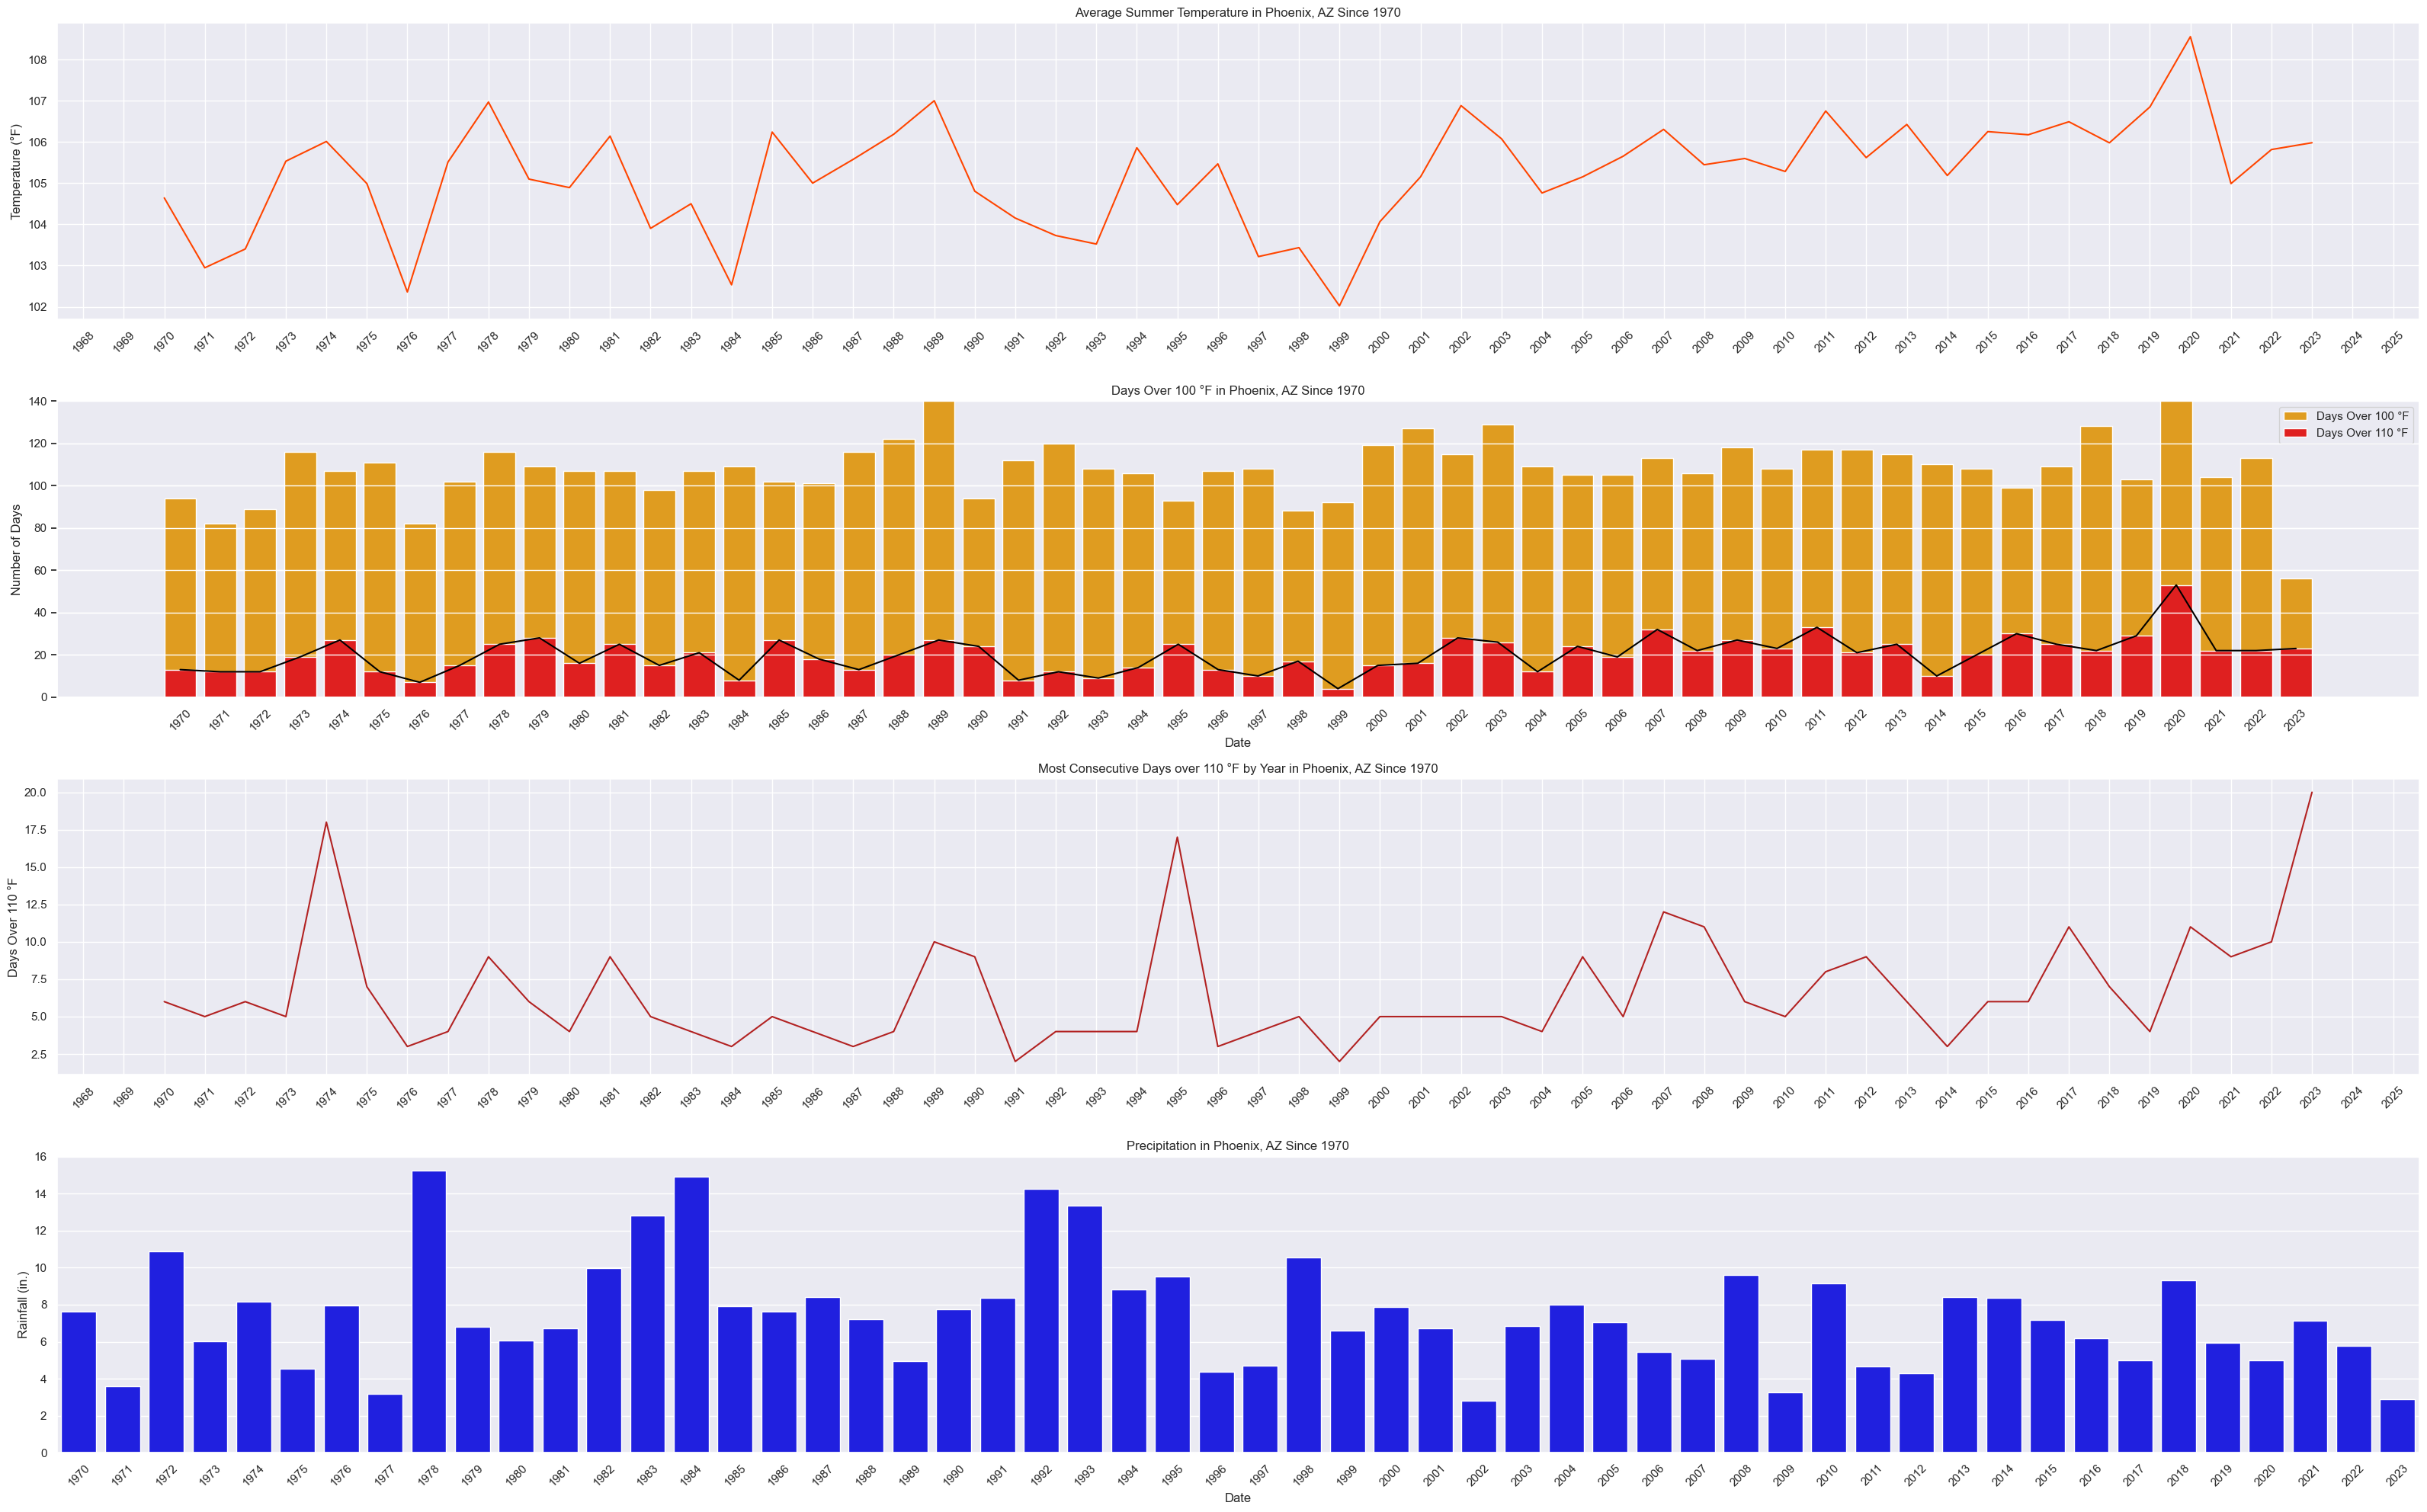

In [98]:
# Use seaborn to make the graphs look nicer
sns.set(style='darkgrid')
sns.set_palette('Reds')
# Create the figure and subplots
fig, (summer_ax, hundreds_ax, consecutive_ax, precipitation_ax) = plt.subplots(4, 1, figsize=(32, 20))
# Plot the summer climate data since 1970
summer_ax.plot(average_summer_temps['Date'], average_summer_temps['Temp_F'], color='orangered')
summer_ax.set_title('Average Summer Temperature in Phoenix, AZ Since 1970')
summer_ax.xaxis.set_major_locator(YearLocator())
summer_ax.xaxis.set_major_formatter(DateFormatter("%Y"))
summer_ax.tick_params('x', rotation=45)
summer_ax.set_ylabel('Temperature (°F)')
# Plot the number of days with 100+ temperatures since 1970
sns.barplot(data=hundred_temperatures, x='Date', y='Days_Over_100', label='Days Over 100 °F', color='orange', ax=hundreds_ax)
sns.barplot(data=hundred_temperatures, x='Date', y='Days_Over_110', label='Days Over 110 °F', color='red', ax=hundreds_ax)
hundreds_ax.tick_params('x', rotation=45)
hundreds_ax.set_ylabel('Number of Days')
hundreds_ax.set_title('Days Over 100 °F in Phoenix, AZ Since 1970')
hundreds_ax.set_ylim(0,140)
hundreds_ax.legend()
# Add a line to the bar plot for temperatures over 110
hundreds_ax_2 = hundreds_ax.twinx()
sns.lineplot(data=hundred_temperatures, x=hundreds_ax.get_xticks(), y='Days_Over_110', ax=hundreds_ax_2, color='black')
hundreds_ax_2.set_ylim(0,140)
hundreds_ax_2.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                   right=False, labelright=False, bottom=False, labelbottom=False)
hundreds_ax_2.set_ylabel('')
# Plot the consecutive number of days with 110+ temperatures
consecutive_ax.plot(consecutive_days_over_110['Date'], consecutive_days_over_110['Temp_F'], color='firebrick')
consecutive_ax.set_title('Most Consecutive Days over 110 °F by Year in Phoenix, AZ Since 1970')
consecutive_ax.xaxis.set_major_locator(YearLocator())
consecutive_ax.xaxis.set_major_formatter(DateFormatter("%Y"))
consecutive_ax.tick_params('x', rotation=45)
consecutive_ax.set_ylabel('Days Over 110 °F')
# Plot the precipitation since 1970
sns.barplot(data=precipitation_count, x='Date', y='Precipitation_in', color='blue', ax=precipitation_ax)
precipitation_ax.tick_params('x', rotation=45)
precipitation_ax.set_ylabel('Rainfall (in.)')
precipitation_ax.set_title('Precipitation in Phoenix, AZ Since 1970')

plt.tight_layout()
plt.show()

In [99]:
# Save the plots
fig.savefig('PhoenixWeatherTrends.png', dpi=300)